# Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
import getpass  # To get the password without showing the input
from sqlalchemy import create_engine, text

Connect to MySQL

In [2]:
password = getpass.getpass()
user = 'root'
database_name = 'ab_test'
connection_string = f'mysql+pymysql://{user}:' + password + '@localhost/' + database_name
engine = create_engine(connection_string)

# Hypotesis 1:
Hypothesis on Client Tenure:

    Null Hypothesis: Those using the new method have an average customer tenure (length of time with Vanguard) that is equal to that of those using the old process.
    
    Alternative Hypothesis: Those using the new method have a different average client tenure than those using the old process.

Get the data from MySQL

In [3]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT client_id, clnt_tenure_yr, clnt_tenure_mnth
            FROM df_final_demo;'''
    query = text(txt)
    result = connection.execute(query)
    data_demo = pd.DataFrame(result.all())

data_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth
0,169,21,262
1,555,3,46
2,647,12,151
3,722,11,143
4,934,9,109
...,...,...,...
70587,9999400,7,86
70588,9999626,9,113
70589,9999729,10,124
70590,9999832,23,281


In [4]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_experiment_clients
    txt = '''SELECT *
            FROM df_final_experiment_clients;'''
    query = text(txt)
    result = connection.execute(query)
    data_client = pd.DataFrame(result.all())

data_client

,client_id,variation
0,169,None
1,555,Test
2,647,Test
3,722,None
4,934,Test
...,...,...
70587,9999400,Test
70588,9999626,Test
70589,9999729,Test
70590,9999832,Test


Statistic Analysis

In [5]:
# Combine data from df_final_demo and df_final_experiment_clients and verify if the Query is working right
combined_data = pd.merge(data_demo, data_client, on='client_id')
combined_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,variation
0,169,21,262,None
1,555,3,46,Test
2,647,12,151,Test
3,722,11,143,None
4,934,9,109,Test
...,...,...,...,...
70587,9999400,7,86,Test
70588,9999626,9,113,Test
70589,9999729,10,124,Test
70590,9999832,23,281,Test


In [6]:
combined_data.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth
count,7.059200e+04,70592.000000,70592.000000
mean,5.005062e+06,12.053051,150.660684
std,2.877304e+06,6.871944,82.091315
min,1.690000e+02,2.000000,33.000000
25%,2.519666e+06,6.000000,82.000000
50%,5.016974e+06,11.000000,136.000000
75%,7.483122e+06,16.000000,192.000000
max,9.999839e+06,62.000000,749.000000


Plot the combined data

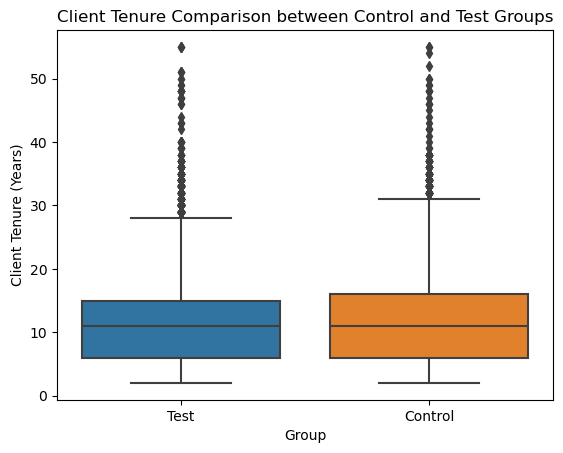

In [7]:
# Create a box plot
sns.boxplot(x='variation', y='clnt_tenure_yr', data=combined_data)
plt.title('Client Tenure Comparison between Control and Test Groups')
plt.xlabel('Group')
plt.ylabel('Client Tenure (Years)')
plt.show()

Separate data for control (old process) and test (new process) groups

In [8]:
# Separate data for control (old process) and test (new process) groups
control_data = combined_data[combined_data['variation'] == 'Control']
test_data = combined_data[combined_data['variation'] == 'Test']

print(f'Test Group: {test_data}')
print(f'Control Group: {control_data}')

Test Group:        client_id  clnt_tenure_yr  clnt_tenure_mnth variation
1            555               3                46      Test
2            647              12               151      Test
4            934               9               109      Test
10          1336              48               576      Test
11          1346              14               177      Test
...          ...             ...               ...       ...
70585    9999150               5                66      Test
70587    9999400               7                86      Test
70588    9999626               9               113      Test
70589    9999729              10               124      Test
70590    9999832              23               281      Test

[26959 rows x 4 columns]
Control Group:        client_id  clnt_tenure_yr  clnt_tenure_mnth variation
5           1028              12               145   Control
6           1104               5                66   Control
7           1186               8

In [9]:
control_data.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth
count,2.352700e+04,23527.000000,23527.000000
mean,5.013661e+06,12.087686,151.060186
std,2.877353e+06,6.877531,82.126443
min,1.028000e+03,2.000000,33.000000
25%,2.515289e+06,6.000000,82.000000
50%,5.023798e+06,11.000000,137.000000
75%,7.483504e+06,16.000000,192.000000
max,9.998921e+06,55.000000,669.000000


In [10]:
test_data.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth
count,2.695900e+04,26959.000000,26959.000000
mean,4.999626e+06,11.983048,149.854779
std,2.877614e+06,6.845175,81.786072
min,5.550000e+02,2.000000,33.000000
25%,2.516451e+06,6.000000,81.500000
50%,5.025928e+06,11.000000,134.000000
75%,7.470346e+06,15.000000,191.000000
max,9.999832e+06,55.000000,669.000000


In [11]:
# Perform t-test for comparing means
t_stat, p_value = ttest_ind(control_data['clnt_tenure_yr'], test_data['clnt_tenure_yr'])

print(f'Statistic: {t_stat}')
print(f'P-Value: {p_value}')

Statistic: 1.7096153693381262
P-Value: 0.08734316699459853


In [12]:
# Analyze the p-value to make a decision about the null hypothesis
if p_value < 0.05:
    print("Don't accept the null hypothesis. The duration of each client is significantly different.")
else:
    print("Reject the null hypothesis without success. The duration of clients does not significantly alter.")

Reject the null hypothesis without success. The duration of clients does not significantly alter.


# Hypotesis 2:
Hypothesis on Client Tenure-Related Completion Rate:

    Null Hypothesis: There is no discernible relationship between client tenure and the new design's completion rate.
    
    Alternative Hypothesis: The new design's completion rate is greatly impacted by the length of the client's stay.

Get the data from MySQL

In [13]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT client_id, clnt_tenure_yr, clnt_tenure_mnth, balance
            FROM df_final_demo;'''
    query = text(txt)
    result = connection.execute(query)
    data_demo = pd.DataFrame(result.all())

data_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,balance
0,169,21,262,501571.0
1,555,3,46,25454.7
2,647,12,151,30525.8
3,722,11,143,22466.2
4,934,9,109,32522.9
...,...,...,...,...
70587,9999400,7,86,51787.0
70588,9999626,9,113,36642.9
70589,9999729,10,124,107060.0
70590,9999832,23,281,431888.0


In [14]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT client_id, process_step, date_time
            FROM df_final_web_data;'''
    query = text(txt)
    result = connection.execute(query)
    data_web = pd.DataFrame(result.all())

data_web

,client_id,process_step,date_time
0,9988021,step_3,2017-04-17 15:27:07
1,9988021,step_2,2017-04-17 15:26:51
2,9988021,step_3,2017-04-17 15:19:22
3,9988021,step_2,2017-04-17 15:19:13
4,9988021,step_3,2017-04-17 15:18:04
...,...,...,...
443765,9895983,step_3,2017-06-15 19:52:09
443766,9895983,step_2,2017-06-15 19:50:37
443767,9895983,step_1,2017-06-15 19:50:05
443768,9895983,start,2017-06-15 19:50:00


In [15]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_experiment_clients
    txt = '''SELECT *
            FROM df_final_experiment_clients;'''
    query = text(txt)
    result = connection.execute(query)
    data_client = pd.DataFrame(result.all())

data_client

,client_id,variation
0,169,None
1,555,Test
2,647,Test
3,722,None
4,934,Test
...,...,...
70587,9999400,Test
70588,9999626,Test
70589,9999729,Test
70590,9999832,Test


Statistic Analysis

In [16]:
# Combine data from df_final_demo, df_final_web_data and df_final_experiment_clients and verify if the Query is working right
combined_data = pd.merge(data_demo, data_web, on='client_id')
combined_data = pd.merge(combined_data, data_client, on='client_id')
combined_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,balance,process_step,date_time,variation
0,169,21,262,501571.0,confirm,2017-04-12 20:23:09,None
1,169,21,262,501571.0,step_3,2017-04-12 20:22:05,None
2,169,21,262,501571.0,step_2,2017-04-12 20:20:31,None
3,169,21,262,501571.0,step_1,2017-04-12 20:19:45,None
4,169,21,262,501571.0,start,2017-04-12 20:19:36,None
...,...,...,...,...,...,...,...
443765,9999839,13,160,67425.4,step_3,2017-03-29 12:12:28,None
443766,9999839,13,160,67425.4,step_2,2017-03-29 12:11:50,None
443767,9999839,13,160,67425.4,step_1,2017-03-29 12:11:35,None
443768,9999839,13,160,67425.4,start,2017-03-29 12:11:32,None


In [17]:
combined_data.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,balance,date_time
count,4.437700e+05,443770.000000,443770.000000,4.437700e+05,443770
mean,5.004557e+06,12.230969,152.777335,1.587750e+05,2017-04-19 23:11:20.176018176
min,1.690000e+02,2.000000,33.000000,1.378940e+04,2017-03-15 00:03:03
25%,2.517762e+06,6.000000,82.000000,3.845850e+04,2017-04-04 13:32:32.249999872
50%,5.025938e+06,11.000000,139.000000,6.673580e+04,2017-04-12 13:14:51
75%,7.473636e+06,16.000000,194.000000,1.487810e+05,2017-04-28 09:53:33
max,9.999839e+06,62.000000,749.000000,1.632000e+07,2017-06-20 23:57:06
std,2.874034e+06,7.002352,83.687297,3.359106e+05,NaN


Plot the combined data

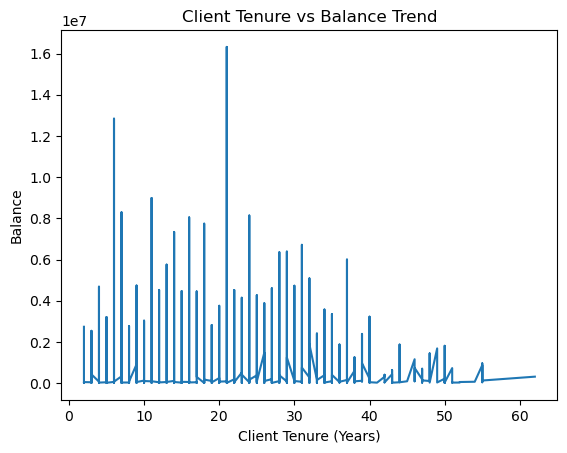

In [18]:
# Line plot
sorted_data = combined_data.sort_values(by='clnt_tenure_yr')
plt.plot(sorted_data['clnt_tenure_yr'], sorted_data['balance'])
plt.xlabel('Client Tenure (Years)')
plt.ylabel('Balance')
plt.title('Client Tenure vs Balance Trend')
plt.show()

In [19]:
# Assuming 'process_step' is the column indicating completion of a certain step
completed_data = combined_data[combined_data['process_step'].isin(['step_3', 'step_2', 'step_1', 'start', 'confirm'])]
completed_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,balance,process_step,date_time,variation
0,169,21,262,501571.0,confirm,2017-04-12 20:23:09,None
1,169,21,262,501571.0,step_3,2017-04-12 20:22:05,None
2,169,21,262,501571.0,step_2,2017-04-12 20:20:31,None
3,169,21,262,501571.0,step_1,2017-04-12 20:19:45,None
4,169,21,262,501571.0,start,2017-04-12 20:19:36,None
...,...,...,...,...,...,...,...
443765,9999839,13,160,67425.4,step_3,2017-03-29 12:12:28,None
443766,9999839,13,160,67425.4,step_2,2017-03-29 12:11:50,None
443767,9999839,13,160,67425.4,step_1,2017-03-29 12:11:35,None
443768,9999839,13,160,67425.4,start,2017-03-29 12:11:32,None


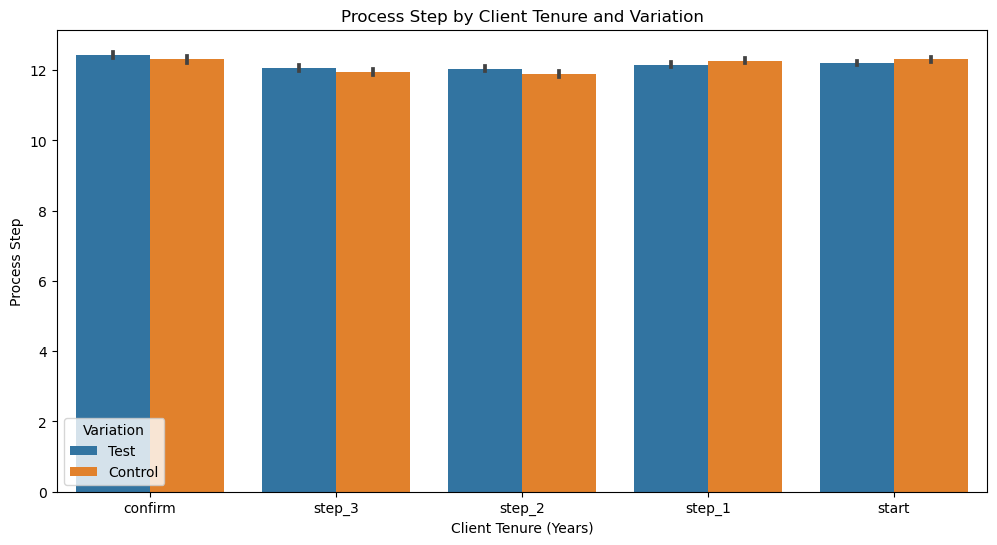

In [20]:
# Create a barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='process_step', y='clnt_tenure_yr', hue='variation', data=completed_data)
plt.xlabel('Client Tenure (Years)')
plt.ylabel('Process Step')
plt.title('Process Step by Client Tenure and Variation')
plt.legend(title='Variation')
plt.show()

Desing the crosstable

In [21]:
completed_data.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,balance,date_time
count,4.437700e+05,443770.000000,443770.000000,4.437700e+05,443770
mean,5.004557e+06,12.230969,152.777335,1.587750e+05,2017-04-19 23:11:20.176018176
min,1.690000e+02,2.000000,33.000000,1.378940e+04,2017-03-15 00:03:03
25%,2.517762e+06,6.000000,82.000000,3.845850e+04,2017-04-04 13:32:32.249999872
50%,5.025938e+06,11.000000,139.000000,6.673580e+04,2017-04-12 13:14:51
75%,7.473636e+06,16.000000,194.000000,1.487810e+05,2017-04-28 09:53:33
max,9.999839e+06,62.000000,749.000000,1.632000e+07,2017-06-20 23:57:06
std,2.874034e+06,7.002352,83.687297,3.359106e+05,NaN


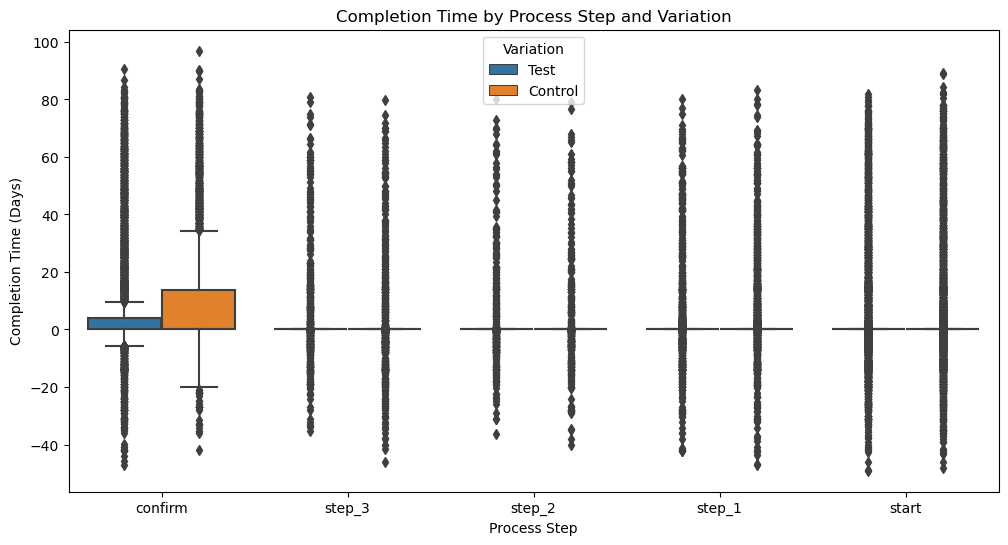

In [22]:
# Assuming 'date_time' is the column indicating the date and time
combined_data['date_time'] = pd.to_datetime(combined_data['date_time'])

# Assuming 'process_step' is the column indicating completion of a certain step
completed_data = combined_data[combined_data['process_step'].isin(['step_3', 'step_2', 'step_1', 'start', 'confirm'])]

# Calculate the completion time for each client
completed_data['completion_time'] = completed_data.groupby('client_id')['date_time'].diff().dt.total_seconds() / (60 * 60 * 24)  # Convert seconds to days

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='process_step', y='completion_time', hue='variation', data=completed_data)
plt.xlabel('Process Step')
plt.ylabel('Completion Time (Days)')
plt.title('Completion Time by Process Step and Variation')
plt.legend(title='Variation')
plt.show()

In [23]:
# Create a contingency table for chi-squared test
contingency_table = pd.crosstab(completed_data['clnt_tenure_yr'], completed_data['process_step'])
contingency_table

process_step,confirm,start,step_1,step_2,step_3
clnt_tenure_yr,,,,,
2,73,153,105,89,81
3,378,1027,605,510,444
4,3763,8928,6120,5330,4448
5,5813,13409,9300,8128,6933
6,5854,13635,9311,8096,6860
7,4200,9624,6676,5611,4854
8,3334,7775,5350,4557,3812
9,2773,6664,4472,3674,3133
10,2301,5557,3773,3124,2633


In [24]:
# Perform chi-squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f'Statistic: {chi2_stat}')
print(f'P-Value: {p_value}')

Statistic: 426.6654338409862
P-Value: 1.4400822927558666e-16


In [25]:
# Analyze the p-value to make a decision about the null hypothesis
if p_value < 0.05:
    print("Don't accept the null hypothesis. Completion rate is greatly impacted by client tenure.")
else:
    print("Reject the null hypothesis without success. The length of a client's stay has little bearing on the completion rate.")

Don't accept the null hypothesis. Completion rate is greatly impacted by client tenure.
